In [21]:
import tensorflow as tf
# from tensorflow import keras 
import pandas as pd 
import numpy as np 
from sklearn.preprocessing import StandardScaler, MinMaxScaler 
import matplotlib.pyplot as plt 
import seaborn as sns 
import os 
from datetime import datetime 

In [22]:
# suppress warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [23]:
df = pd.read_csv("commodity_historical.csv")
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 780 entries, 0 to 779
Data columns (total 4 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   date                   780 non-null    object 
 1   Crude Oil Brent Price  780 non-null    float64
 2   Cocoa Price            780 non-null    float64
 3   Gold Price             780 non-null    float64
dtypes: float64(3), object(1)
memory usage: 24.5+ KB


In [24]:
data = df[["date", "Cocoa Price"]]
data.head()
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 780 entries, 0 to 779
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         780 non-null    object 
 1   Cocoa Price  780 non-null    float64
dtypes: float64(1), object(1)
memory usage: 12.3+ KB


In [25]:
data['date'] = pd.to_datetime(data['date'])

/var/folders/rd/tqc_535n6bb2mkqrf4_7nf6w0000gn/T/ipykernel_30718/736794659.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [26]:
data = data[data["date"] >= "1980-01-01"]  # instead of 1960 which is statistically insignificant

In [27]:
import plotly.express as px
import plotly.graph_objects as go


def plotting(title, data, x, y, x_label, y_label, text=False, lam=None):
    """General function to plot the data."""
    fig = px.line(data, x=data[x], y=data[y], labels={x: x_label, y: y_label})
    fig.update_layout(template="simple_white", font=dict(size=18), title_text=title, width=650, title_x=0.5, height=400)
    if text:
      fig.add_annotation(
          x='1952-12-20', y=10, text=f'Lambda = {lam:.3f}',
          align='left', yanchor='bottom', showarrow=False,
          font=dict(size=20, color="black", family="Courier New, monospace"),
          bordercolor='black', borderwidth=2, bgcolor="white"
      )
    fig.show()


def add_separator(width=650):
    """Add a horizontal line as a separator."""
    fig = go.Figure()
    fig.add_hline(y=0.5, line_dash="dot", line_color="gray", line_width=2)
    fig.update_layout(height=50, width=width, margin=dict(l=20, r=20, t=20, b=20), xaxis_visible=False, yaxis_visible=False)
    fig.show()


In [28]:
plotting(title='Cocoa Over Time', data=data, x='date', y='Cocoa Price', x_label='Date', y_label='Price ()')
# add_separator()

In [29]:
len(data)

540

## Data Split

In [30]:
train = data.iloc[:528]  # 1980 to 2023
test = data.iloc[528:]  # 2024

In [31]:
# scaler = StandardScaler()
scaler = MinMaxScaler()
# scaled_data = scaler.fit_transform(data["Crude Oil Brent Price"])
scaler.fit(train[["Cocoa Price"]])
scaled_train = scaler.transform(train[["Cocoa Price"]])
scaled_test = scaler.transform(test[["Cocoa Price"]])

In [32]:
train_size = int(len(scaled_train) * 0.95)  # 95% train, 5% validation
train_data, val_data = scaled_train[:train_size], scaled_train[train_size:]

In [33]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

# Define Parameters
lookback = 10  # Number of past steps to use as input
batch_size = 32  # Number of samples per batch
n_features = 1

# Initialize Generator
# train_generator = TimeseriesGenerator(scaled_train, scaled_train, length=lookback, batch_size=batch_size)
train_generator = TimeseriesGenerator(train_data, train_data, length=lookback, batch_size=batch_size)
val_generator = TimeseriesGenerator(val_data, val_data, length=lookback, batch_size=batch_size)

## Build base lstm

In [34]:
# Build LSTM model
model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(256, return_sequences=True, input_shape=(lookback, n_features)),  # 1st layer with 170 units as specified
    # tf.keras.layers.LSTM(64, return_sequences=False),  # 2nd layer
    # tf.keras.layers.Dense(128, activation="relu"),  # 3rd Layer (Dense)
    # tf.keras.layers.Dropout(0.1),  # 4th Layer (Dropout)
    tf.keras.layers.Dense(1)  # Final Output Layer
])

# Configure ADAM optimizer with specified parameters
optimizer = tf.keras.optimizers.Adam(
    learning_rate=0.001,  # Specified learning rate
    beta_1=0.9,  # First moment estimate decay rate
    beta_2=0.999  # Second moment estimate decay rate
)

model.compile(
    optimizer=optimizer, 
    loss="mean_squared_error",  # Root Mean Squared Error (RMSE)
    metrics=["MeanAbsolutePercentageError"]
)

# Set random seed for reproducibility
tf.random.set_seed(3)

/opt/anaconda3/envs/ML/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



In [35]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 10, 256)        │       264,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10, 1)          │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 264,449 (1.01 MB)

 Trainable params: 264,449 (1.01 MB)

 Non-trainable params: 0 (0.00 B)

In [36]:
# fit model
model.fit(train_generator, epochs=50)

Epoch 1/50


/opt/anaconda3/envs/ML/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - MeanAbsolutePercentageError: 65470.7109 - loss: 0.0828
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - MeanAbsolutePercentageError: 33812.4453 - loss: 0.0289
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - MeanAbsolutePercentageError: 625684.1875 - loss: 0.0145
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - MeanAbsolutePercentageError: 92545.6016 - loss: 0.0191
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - MeanAbsolutePercentageError: 94970.5781 - loss: 0.0144
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - MeanAbsolutePercentageError: 84828.4766 - loss: 0.0136
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - MeanAbsolutePercentageError: 55659.2305 - loss: 0.0104
Epoch 8/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - MeanAbsolutePercentageError: 138185.0781 - loss: 0.0148
Epoch 9/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - MeanAbsolutePercentageError: 226475.7500 - loss: 0.0124
Epoch 10/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 

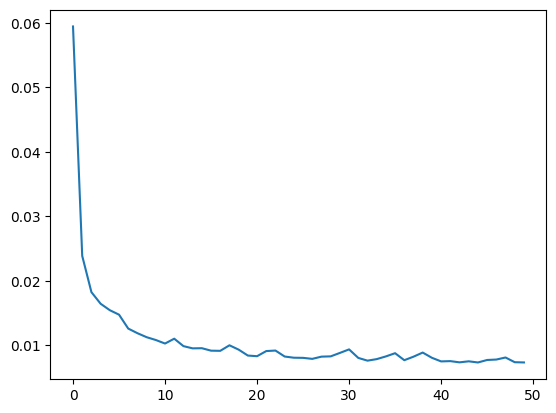

In [37]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [38]:
def plot_forecasts(df: pd.DataFrame, forecasts: np.ndarray, col: str, title: str) -> None:
    """Function to plot the forecasts."""
    fig = go.Figure()
    
    # Plot true values
    fig.add_trace(go.Scatter(x=df['date'], y=df[col], name='Truth', mode='lines'))
    
    # Plot predicted values
    fig.add_trace(go.Scatter(x=df['date'], y=forecasts.flatten(), name='Prediction', mode='lines'))
    
    fig.update_layout(
        template="simple_white", font=dict(size=18), title_text=title,
        width=650, title_x=0.5, height=400, xaxis_title='Date', yaxis_title='Price'
    )
    
    fig.show()

## Train set

In [51]:
# train_predictions = []

# first_eval_batch = scaled_train[:lookback]
# current_batch = first_eval_batch.reshape((1, lookback, n_features))

# for i in range(len(train)):
    
#     # get the prediction value for the first batch
#     current_pred = model.predict(current_batch)[0]
    
#     # append the prediction into the array
#     train_predictions.append(current_pred) 
    
#     # use the prediction to update the batch and remove the first value
#     current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)


input_sequence = scaled_train  #np.vstack([scaled_train[:lookback], scaled_train])

# Initialize predictions array
train_predictions = []

# For each point in the test set
for i in range(len(scaled_train)):
    # Extract the current window (LOOKBACK previous points)
    current_window = input_sequence[i:i+lookback].reshape(1, lookback, n_features)
    
    # Generate prediction for the next point
    pred = model.predict(current_window)[0]
    train_predictions.append(pred)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━

ValueError: cannot reshape array of size 9 into shape (1,10,1)

In [ ]:
# Ensure test predictions is a 2D NumPy array before inverse scaling
true_predictions = scaler.inverse_transform(np.array(train_predictions).reshape(-1, 1))

# Extract correct test set dates
train_dates = data['date'].iloc[:len(train)]

In [ ]:
plot_forecasts(
    pd.DataFrame({
        'date': train_dates, 
        "Cocoa Price": train["Cocoa Price"].values
    }), 
    true_predictions, 
    "Cocoa Price", 
    "LSTM forecast for Cocoa train set"
)

## Test set

In [41]:
# test_predictions = []

# first_eval_batch = scaled_train[-lookback:]
# current_batch = first_eval_batch.reshape((1, lookback, n_features))

# for i in range(len(test)):
    
#     # get the prediction value for the first batch
#     current_pred = model.predict(current_batch)[0]
    
#     # append the prediction into the array
#     test_predictions.append(current_pred) 
    
#     # use the prediction to update the batch and remove the first value
#     current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)


input_sequence = np.vstack([scaled_train[-lookback:], scaled_test])

# Initialize predictions array
test_predictions = []

# For each point in the test set
for i in range(len(scaled_test)):
    # Extract the current window (LOOKBACK previous points)
    current_window = input_sequence[i:i+lookback].reshape(1, lookback, n_features)
    
    # Generate prediction for the next point
    pred = model.predict(current_window)[0]
    test_predictions.append(pred)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


In [42]:
# Ensure test predictions is a 2D NumPy array before inverse scaling
true_predictions = scaler.inverse_transform(np.array(test_predictions).reshape(-1, 1))

# Extract correct test set dates
test_dates = data['date'].iloc[len(train):]

In [43]:
plot_forecasts(
    pd.DataFrame({
        'date': test_dates, 
        "Cocoa Price": test["Cocoa Price"].values
    }), 
    true_predictions, 
    "Cocoa Price", 
    "LSTM forecast for Cocoa test set"
)

In [44]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse=sqrt(mean_squared_error(test['Cocoa Price'], true_predictions))
rmse

ValueError: Found input variables with inconsistent numbers of samples: [12, 120]

In [26]:
model.save("cocoa_lstm_model.keras")

## Grid Search Hyperparameter Tuning

In [27]:
import keras_tuner as kt

# Set random seed for reproducibility
tf.random.set_seed(3)

# Assume `train_data` and `val_data` are numpy arrays (shape: [samples, features])
n_features = train_data.shape[1]

# Tune batch sizes
batch_sizes = [16, 32, 64]

# Create dictionary to store generators for different batch sizes
generators = {}

for batch_size in batch_sizes:
    generators[batch_size] = {
        'train': TimeseriesGenerator(train_data, train_data[:, -1], length=24, batch_size=batch_size),
        'val': TimeseriesGenerator(val_data, val_data[:, -1], length=24, batch_size=batch_size)
    }

def build_model(hp):
    """
    Model builder function for Keras Tuner
    """

    # Tune the lookback period
    lookback = hp.Int('lookback', min_value=1, max_value=24, step=1)

    model = tf.keras.models.Sequential()

    # Tune the number of units in the first LSTM layer
    units_1 = hp.Int('units_1', min_value=32, max_value=256, step=32)
    model.add(tf.keras.layers.LSTM(
        units=units_1,
        return_sequences=True,
        input_shape=(lookback, n_features)
    ))

    # Tune the number of units in the second LSTM layer
    units_2 = hp.Int('units_2', min_value=32, max_value=128, step=32)
    model.add(tf.keras.layers.LSTM(
        units=units_2,
        return_sequences=False
    ))

    # Tune the number of units in the dense layer
    units_dense = hp.Int('units_dense', min_value=64, max_value=256, step=64)
    model.add(tf.keras.layers.Dense(units=units_dense, activation='relu'))

    # Tune the dropout rate
    dropout_rate = hp.Float('dropout_rate', min_value=0.0, max_value=0.5, step=0.1)
    model.add(tf.keras.layers.Dropout(rate=dropout_rate))

    # Output layer
    model.add(tf.keras.layers.Dense(1))

    # Tune the learning rate
    learning_rate = hp.Choice('learning_rate', values=[1e-4, 5e-4, 1e-3, 5e-3])
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    model.compile(
        optimizer=optimizer,
        loss='mean_squared_error',
        metrics=['MeanAbsolutePercentageError']
    )

    return model

# Initialize the tuner
tuner = kt.GridSearch(
    build_model,
    objective='val_loss',
    max_trials=20,  # Number of different hyperparameter combinations to try
    directory='tuning_dir',
    project_name='cocoa_lstm_tuning'
)

# Print search space summary
tuner.search_space_summary()

# Tune epochs
epoch_choices = [50, 100, 150]

# Define early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# Start the hyperparameter search
for batch_size in batch_sizes:
    tuner.search(
        generators[batch_size]['train'],
        epochs=max(epoch_choices),
        validation_data=generators[batch_size]['val'],
        callbacks=[early_stopping]
    )

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
Best hyperparameters found:
- Lookback: {best_hps.get('lookback')}
- First LSTM layer units: {best_hps.get('units_1')}
- Second LSTM layer units: {best_hps.get('units_2')}
- Dense layer units: {best_hps.get('units_dense')}
- Dropout rate: {best_hps.get('dropout_rate')}
- Learning rate: {best_hps.get('learning_rate')}
""")

# Tune Batch Size & Epochs
best_batch_size = None
best_epoch = None
best_val_loss = float('inf')

for batch_size in batch_sizes:
    for epochs in epoch_choices:
        print(f"Testing batch size {batch_size} with {epochs} epochs...")

        # Build the best model found
        model = tuner.hypermodel.build(best_hps)

        # Train with current batch size & epochs
        history = model.fit(
            generators[batch_size]['train'],
            epochs=epochs,
            validation_data=generators[batch_size]['val'],
            callbacks=[early_stopping],
            verbose=0  # Suppress output for cleaner logs
        )

        # Get the final validation loss
        final_val_loss = min(history.history['val_loss'])

        # Update best batch size & epoch count if a lower val_loss is found
        if final_val_loss < best_val_loss:
            best_val_loss = final_val_loss
            best_batch_size = batch_size
            best_epoch = epochs

print(f"""
Best batch size and epoch found:
- Batch size: {best_batch_size}
- Epochs: {best_epoch}
- Final validation loss: {best_val_loss}
""")

# Train the Best Model with Best Batch Size & Epochs
best_model = tuner.hypermodel.build(best_hps)

history = best_model.fit(
    generators[best_batch_size]['train'],
    epochs=best_epoch,
    validation_data=generators[best_batch_size]['val'],
    callbacks=[early_stopping]
)

# Save the best model
best_model.save('best_cocoa_lstm_model.keras')


Trial 20 Complete [00h 00m 05s]
val_loss: 0.009678877890110016

Best val_loss So Far: 0.003281010314822197
Total elapsed time: 00h 02m 55s

Best hyperparameters found:
- Lookback: 1
- First LSTM layer units: 32
- Second LSTM layer units: 32
- Dense layer units: 64
- Dropout rate: 0.0
- Learning rate: 0.005

Testing batch size 16 with 50 epochs...
Testing batch size 16 with 100 epochs...
Testing batch size 16 with 150 epochs...
Testing batch size 32 with 50 epochs...
Testing batch size 32 with 100 epochs...
Testing batch size 32 with 150 epochs...
Testing batch size 64 with 50 epochs...
Testing batch size 64 with 100 epochs...
Testing batch size 64 with 150 epochs...

Best batch size and epoch found:
- Batch size: 16
- Epochs: 150
- Final validation loss: 0.001924096723087132

Epoch 1/150
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - MeanAbsolutePercentageError: 399005.3438 - loss: 0.0318 - val_MeanAbsolutePercentageError: 52.7233 - val_loss: 0.2425
Epoch 2/150
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 

In [28]:
test_predictions = []

first_eval_batch = scaled_train[-best_hps.get('lookback'):]
current_batch = first_eval_batch.reshape((1, best_hps.get('lookback'), n_features))

for i in range(len(test)):
    
    # get the prediction value for the first batch
    current_pred = best_model.predict(current_batch)[0]
    
    # append the prediction into the array
    test_predictions.append(current_pred) 
    
    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)


# Ensure test predictions is a 2D NumPy array before inverse scaling
true_predictions = scaler.inverse_transform(np.array(test_predictions).reshape(-1, 1))
# Extract correct test set dates
test_dates = data['date'].iloc[len(train):]


plot_forecasts(
    pd.DataFrame({
        'date': test_dates, 
        "Cocoa Price": test["Cocoa Price"].values
    }), 
    true_predictions, 
    "Cocoa Price", 
    "LSTM Best forecast for Cocoa test set"
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


In [29]:
best_model.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_20 (LSTM)                  │ (None, 1, 32)          │         4,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_21 (LSTM)                  │ (None, 32)             │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 44,549 (174.02 KB)

 Trainable params: 14,849 (58.00 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 29,700 (116.02 KB)

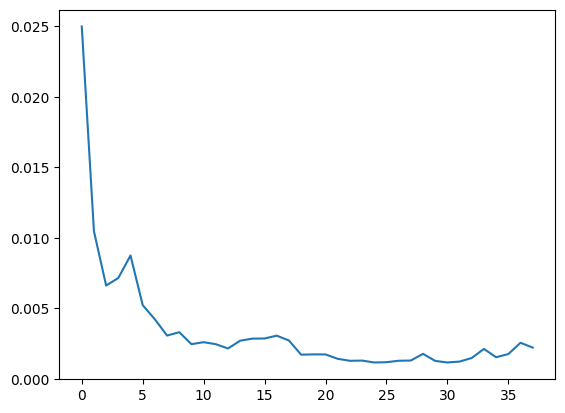

In [30]:
loss_per_epoch = best_model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)